# Отток клиентов банка

## Описание проекта

Для банка "Бета-Банк" стал заметным уход клиентов каждый месяц, что может привести к значительным потерям. Чтобы избежать этого, необходимо сохранить текущих клиентов, поскольку это дешевле, чем привлекать новых. Для этого требуется спрогнозировать, уйдет ли клиент из банка в ближайшее время или нет. В распоряжении маркетологов есть исторические данные о поведении клиентов и расторжении договоров с банком. Основная задача заключается в построении модели с предельно большим значением F1-меры, которая позволит наиболее точно прогнозировать, уйдет ли клиент из банка. Для успешной сдачи проекта необходимо довести метрику до значения не менее 0.59.

## Описание данных

**Признаки**

* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**
* `Exited` — факт ухода клиента

## Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# warnings.filterwarnings('ignore')
RANDOM_SEED = 150797

## Загрузка данных, подготовка и анализ

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
except:
    data = pd.read_csv('Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# cкорректируем названия колонок
new_columns = {'RowNumber': 'row_number',
               'CustomerId': 'customer_id',
               'Surname': 'surname',
               'CreditScore': 'credit_score',
               'Geography': 'geography',
               'Gender': 'gender',
               'Age': 'age',
               'Tenure': 'tenure',
               'Balance': 'balance',
               'NumOfProducts': 'num_of_products',
               'HasCrCard': 'has_cr_card',
               'IsActiveMember': 'is_active_member',
               'EstimatedSalary': 'estimated_salary',
               'Exited': 'exited'}

data = data.rename(columns=new_columns)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Типы данных указаны корректно. Пропуски присутствуют только в столбце `tenure` - сколько лет человек является клиентом банка. Обработаем этот фактор дальше.

In [6]:
# удалим факторы, которые не понадобятся для обучения
data = data.drop(columns=['row_number', 'customer_id', 'surname'])

In [7]:
data.describe(include='all')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


## Предобработка данных
### Обработка пропусков
#### `tenure` - сколько лет человек является клиентом банка

In [8]:
print('Процент пропуков в факторе tenure:')
print(data['tenure'].isna().sum()/data.count().sum()*100)

Процент пропуков в факторе tenure:
0.8332493056255786


Наблюдаем, что в данных процент пропусков составляет <1%, поэтому просто удалим клиентов, у которых не указано как долго они являются клиентами банка

In [9]:
data = data.dropna(subset=['tenure'])

In [10]:
data.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### Обработка дубликатов
#### Явные дубликаты

In [11]:
data.duplicated().sum()

0

#### Неявные дубликаты

In [12]:
data['geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: geography, dtype: int64

In [13]:
data['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

Неявные дубликаты в столбцах, где они могли бы быть тоже не обнаружены

### Сбалансированность классов

In [14]:
counts = data['exited'].value_counts()
percent100 = data['exited'].value_counts(normalize=True).mul(100).round(1).astype('str')+'%'
pd.DataFrame({'counts': counts, 'per100': percent100})

,counts,per100
0,7237,79.6%
1,1854,20.4%


Клиентов, которые относятся к классу 0 почти в 4 раза больше. Посмотрим как отработают данные в моделях без всяких изменений, а затем сбалансируем классы.

### Кодировка признаков

In [15]:
# получим дамми переменные для факторов, в которых не слишком много yникальных значений
categories_oh_enc = ['geography', 'gender']
data = pd.get_dummies(data, columns=categories_oh_enc, drop_first=True)

### Формирование обучающей, валидационной и тестовой выборки

In [16]:
# сделаем разбивку данных в соотношении 70/15/15
train, test_val = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED, stratify=data['exited'])
test, val = train_test_split(test_val, test_size=0.5, random_state=RANDOM_SEED, stratify=test_val['exited'])

print('Размер обучающей выборки:', train.shape)
print('Размер валидационной выборки:', val.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (6363, 12)
Размер валидационной выборки: (1364, 12)
Размер тестовой выборки: (1364, 12)


In [17]:
# выделим факторы и целевую переменную
X_train, y_train = train.drop(columns=['exited']), train['exited']
X_val, y_val = val.drop(columns=['exited']), val['exited']
X_test, y_test = test.drop(columns=['exited']), test['exited']

В данном проекте будем строить модель случайного леса, для которого не требуется масштабирование данных

## Построение моделей
### Предсказание константой

In [18]:
y_val.value_counts()

0    1086
1     278
Name: exited, dtype: int64

In [19]:
predictions = pd.Series([y_val.value_counts().index[0]]*y_val.shape[0], index=y_val.index)
rfc_res = f1_score(y_val, predictions)
print(rfc_res)

0.0


Очевидно, что выдавая предсказания, что все клиенты остнутся клиентами банка получим f1-метрику равную 0.

### Модель случайного леса с дисбалансом классов
Построим модель случайного леса с дисбалансом классов и посмотрим, как она себя показывает

In [20]:
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED,
                                       max_depth=13,
                                       n_estimators=50)
rfc_model.fit(X_train, y_train)
predictions = rfc_model.predict(X_val)
y_pred_proba = rfc_model.predict_proba(X_val)[::,1]

rfc_res_f1 = f1_score(y_val, predictions)
# rfc_res_roc_auc = roc_auc_score(y_val, predictions) удалю
rfc_res_roc_auc = roc_auc_score(y_val, y_pred_proba)
print('ROC-AUC:', rfc_res_roc_auc)
print('F1-score:', rfc_res_f1)

ROC-AUC: 0.8521337626031772
F1-score: 0.5371702637889688


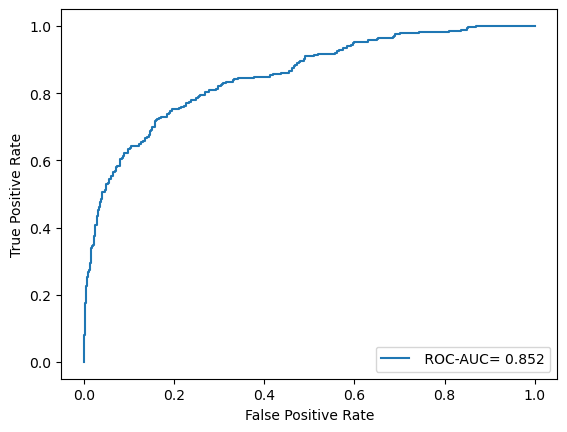

In [21]:
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

plt.plot (fpr,tpr,label=" ROC-AUC= "+str(rfc_res_roc_auc)[:5])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

In [22]:
print('F1 модели случайного леса на тестовой выборке:',
      f1_score(y_test, rfc_model.predict(X_test)))

F1 модели случайного леса на тестовой выборке: 0.5301204819277109


In [23]:
predictions = rfc_model.predict(X_test)
confusion_matrix(y_test, predictions)

array([[1059,   27],
       [ 168,  110]])

Обучив модель случайного леса на данных, в которых присутствует дисбаланс классов видно, что модель достаточно плохо определяет клиентов, которые уйдут в отток. Получаем значение основной метрики (f1-score) на валидации - 0.537, ROC-AUC - 0.852 

### Модель случайного леса без дисбаланса классов
#### Уменьшение выборки

In [24]:
def downsampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_SEED)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_SEED)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_SEED)
    
    return features_downsampled, target_downsampled



In [25]:
frac = len(X_train[y_train==1])/len(X_train[y_train==0])
X_train_downsampled, y_train_downsampled = downsampling(X_train, y_train, frac)

In [26]:
params = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'max_depth': [10, 15, 20, 30, 40, 50]
}

# rfc_model = RandomForestClassifier(random_state=RANDOM_SEED)
# grid_search_rfc = GridSearchCV(estimator=rfc_model,
#                                param_grid=params,
#                                cv=5,
#                                scoring='f1')
# grid_search_rfc.fit(X_train_downsampled, y_train_downsampled)
# grid_search_rfc.best_params_

# OUTPUT:
# {'criterion': 'entropy',
#  'max_depth': 15,
#  'max_features': 'auto',
#  'n_estimators': 500}

In [27]:
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED,
                                   criterion='entropy',
                                   max_depth=15,
                                   max_features='auto',
                                   n_estimators=700)
rfc_model.fit(X_train_downsampled, y_train_downsampled)
predictions = rfc_model.predict(X_val)
y_pred_proba = rfc_model.predict_proba(X_val)[::,1]

rfc_res_f1 = f1_score(y_val, predictions)
rfc_res_roc_auc = roc_auc_score(y_val, y_pred_proba)
print('ROC-AUC:', rfc_res_roc_auc)
print('F1-score:', rfc_res_f1)

ROC-AUC: 0.8421274030499358
F1-score: 0.5636623748211731


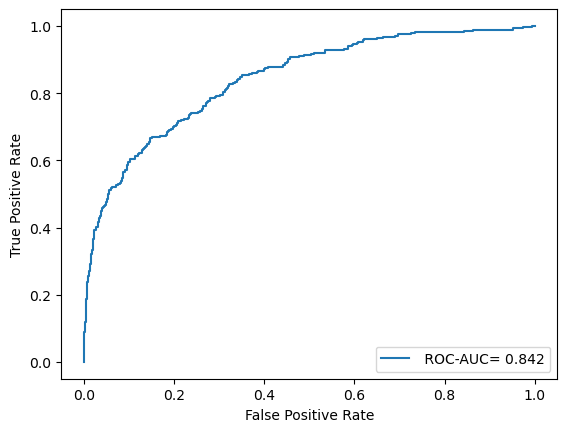

In [28]:
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

plt.plot (fpr,tpr,label=" ROC-AUC= "+str(rfc_res_roc_auc)[:5])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

In [29]:
print('F1 модели случайного леса на тестовой выборке:',
      f1_score(y_test, rfc_model.predict(X_test)))

F1 модели случайного леса на тестовой выборке: 0.5971428571428571


In [30]:
predictions = rfc_model.predict(X_test)
confusion_matrix(y_test, predictions)

array([[873, 213],
       [ 69, 209]])

После того как обучающая выборка была сбалансирована с помощью уменьшения преобладающего класса значение f1 метрики вырасло с 0.53 до 0.59 и по матрице ошибок видно, что теперь модель примерно одинаково определяет 0 и 1 классы. Модель стала лучше предказывать клиентов, которые откажутся от услуг банка.

#### Увеличение выборки

In [31]:
def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_SEED)
    
    return features_upsampled, target_upsampled

In [32]:
repeat = round(len(X_train[y_train==0])/len(X_train[y_train==1]))
X_train_upsampled, y_train_upsampled = upsampling(X_train, y_train, repeat)

In [33]:
params = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'max_depth': [10, 15, 20, 30, 40, 50]
}

# rfc_model = RandomForestClassifier(random_state=RANDOM_SEED)
# grid_search_rfc = GridSearchCV(estimator=rfc_model,
#                                param_grid=params,
#                                cv=5,
#                                scoring='f1')
# grid_search_rfc.fit(X_train_upsampled, y_train_upsampled)
# grid_search_rfc.best_params_

# OUTPUT:
# {'criterion': 'gini',
#  'max_depth': 30,
#  'max_features': 'auto',
#  'n_estimators': 500}

In [34]:
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED,
                                   criterion='gini',
                                   max_depth=30,
                                   max_features='auto',
                                   n_estimators=500)
rfc_model.fit(X_train_upsampled, y_train_upsampled)
predictions = rfc_model.predict(X_val)
y_pred_proba = rfc_model.predict_proba(X_val)[::,1]

rfc_res_f1 = f1_score(y_val, predictions)
rfc_res_roc_auc = roc_auc_score(y_val, y_pred_proba)
print('ROC-AUC:', rfc_res_roc_auc)
print('F1-score:', rfc_res_f1)

ROC-AUC: 0.8415378194681824
F1-score: 0.5850622406639003


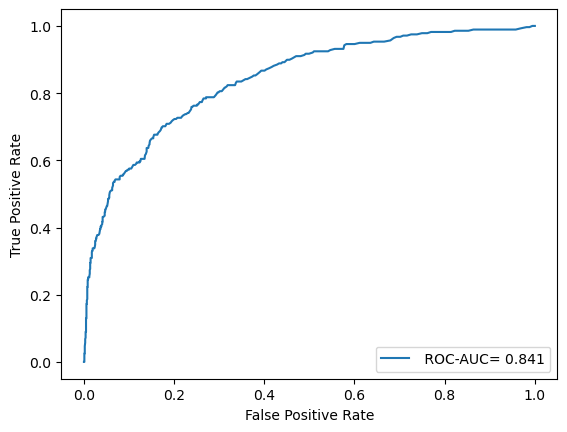

In [35]:
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

plt.plot (fpr,tpr,label=" ROC-AUC= "+str(rfc_res_roc_auc)[:5])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

In [36]:
print('F1 модели случайного леса на тестовой выборке:',
      f1_score(y_test, rfc_model.predict(X_test)))

F1 модели случайного леса на тестовой выборке: 0.5945945945945946


In [37]:
predictions = rfc_model.predict(X_test)
confusion_matrix(y_test, predictions)

array([[1026,   60],
       [ 135,  143]])

В результате балансировки классов, с помощью увеличения доли меньшего класса, значение метрики f1 приблизилось к 0.59 на валидационной выборке. По матрице ошибок также видно, что достаточно большое количество False Positive предсказаний сохраняется.

Параллельно проводилась проверка моделей на тестовой выборке. Результаты метрики f1 следующие:
1. Модель с дисбалансом классов: 0.53
2. Модель со сбалансированными классами с помощью уменьшения выборки: 0.597
3. Модель со сбалансированными классами с помощью увеличения выборки: 0.594

В качестве лучшей модели остановимся на модели №2

## Общий вывод

В результате выполнения данного проекта была обучена модель классификации, способная прогнозировать отток клиентов банка. Поскольку данные для обучения изначально несбалансированы (79.6% - класс `0` и 20.4% - класс `1`) - для корректного обучения модели необходимо было их сбалансировать. В результате чего, в качестве лучшей модели была отобрана модель случайного леса, обученная на данных, в которых преобладающий класс был уменьшен до размеров "недостающего". 

Данная модель показала значение целевой метрики (f1-score) на тестовом датасете - 0.597. Также модель была оценена с помощью метрики ROC-AUC, которая равняется 0.841